<a href="https://colab.research.google.com/github/qkrwoghd04/ImageCaptionnng_Using_ViT/blob/master/practice/Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Image Captioning helps to classify Sleep & Fall

In [1]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package libcudnn8 is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Version '8.1.0.77-1+cuda11.2' for 'libcudnn8' was not found


In [2]:
!pip uninstall -y tensorflow estimator keras

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
Found existing installation: keras 2.15.0
Uninstalling keras-2.15.0:
  Successfully uninstalled keras-2.15.0


In [3]:
!pip install -U tensorflow_text tensorflow tensorflow_datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 78.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 73.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 33.0 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      S

In [4]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.1 MB/s eta 0:00:00


In [5]:
!pip install tensorflow-estimator==2.10.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0


In [6]:
#@title
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm

import tensorflow as tf

In [7]:
def custom_conceptual_captions(data_dir="/content/drive/MyDrive/image_dataset/processed", num_train=400):
    def iter_index(index_path):
        with open(index_path) as f:
            for line in f:
                parts = line.strip().split(', ')
                caption = parts[1]  # 캡션은 두 번째 부분
                url = parts[0]  # 이미지 파일 경로는 첫 번째 부분
                yield caption, url

    def ds_from_index_file(index_path, data_dir, count):
        data_dir.mkdir(exist_ok=True)
        index = list(iter_index(index_path))[:count]

        new_captions = []
        new_paths = []
        for caption, url in index:
            filename = url.split('/')[-1]
            category = filename.split('_')[0]  # "Fall" 또는 "Sleep"을 가져옴
            image_path = data_dir / category / filename
            new_captions.append(caption)
            new_paths.append(str(image_path))

        ds = tf.data.Dataset.from_tensor_slices((new_paths, new_captions))
        return ds

    data_dir = pathlib.Path(data_dir)  # 문자열을 pathlib 객체로 변환
    train_index_path = data_dir / "captions.txt"
    train_raw = ds_from_index_file(train_index_path, data_dir=data_dir, count=num_train)

    return train_raw

# 사용 예시
train_raw = custom_conceptual_captions()

In [8]:
train_raw.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.string, name=None))

In [9]:
for ex_path, ex_captions in train_raw.take(1):
  print(ex_path)
  print(ex_captions)

tf.Tensor(b'/content/drive/MyDrive/image_dataset/processed/Fall/Fall_001.jpg', shape=(), dtype=string)
tf.Tensor(b'a man lying on the ground in a hallway.', shape=(), dtype=string)


In [10]:
# 이미지의 특성을 추출하기위해 사전 훈련된 mobilenet model을 가지고 온다
IMAGE_SHAPE=(224, 224, 3)
mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True)
mobilenet.trainable=False

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

In [12]:
test_img_batch = load_image(ex_path)[tf.newaxis, :]

print(test_img_batch.shape)
print(mobilenet(test_img_batch).shape)

(1, 224, 224, 3)
(1, 7, 7, 576)


In [13]:
#정규화(input string에 대해서 소문자로 통일하고, )
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

In [14]:
# Use the top 5000 words for a vocabulary.
vocabulary_size = 500
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)
# If ragged=False
# "Hello world" → [token1, token2, pad_token] (길이: 3)
# "TensorFlow is great" → [token3, token4, token5] (길이: 3)
# "Examples" → [token6, pad_token, pad_token] (길이: 3)
# Learn the vocabulary from the caption data.

In [15]:
# 먼저, train_ds에서 캡션 데이터만 추출합니다.
captions_ds = train_raw.map(lambda fp, txt: txt)

# tokenizer를 캡션 데이터에 적응시킵니다.
tokenizer.adapt(captions_ds.batch(1024))

In [16]:
tokenizer.get_vocabulary()[:10]

['', '[UNK]', 'a', '[START]', '[END]', 'on', 'lying', 'in', 'the', 'man']

In [17]:
t = tokenizer([['a man lying on the groud'], ['a lying women']])
t

<tf.RaggedTensor [[3, 2, 9, 6, 5, 8, 1, 4], [3, 2, 6, 1, 4]]>

In [18]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [19]:
w = index_to_word(t)
w.to_list()

[[b'[START]', b'a', b'man', b'lying', b'on', b'the', b'[UNK]', b'[END]'],
 [b'[START]', b'a', b'lying', b'[UNK]', b'[END]']]

In [20]:
tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

array([b'[START] a man lying on the [UNK] [END]',
       b'[START] a lying [UNK] [END]'], dtype=object)

In [21]:
# # captions 배열의 형태를 파싱하여 배치 크기b와 캡션 길이c를 가져옵니다
# def match_shapes(images, captions):
#   caption_shape = einops.parse_shape(captions, 'b c')
#   captions = einops.rearrange(captions, 'b c -> (b c)')
#   images = einops.repeat(
#       images, 'b ... -> (b c) ...',
#       c = caption_shape['c'])
#   return images, captions
def match_shapes(images, captions):
    # 이미 이미지와 캡션은 1:1 매칭이므로 별도의 형태 조정이 필요하지 않습니다.
    # 함수가 단순히 입력된 images와 captions을 그대로 반환하도록 수정합니다.
    return images, captions


In [22]:
for ex_paths, ex_captions in train_raw.batch(32).take(1):
  break

print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)

image paths: (32,)
captions: (32,)

image_paths: (32,)
captions: (32,)


In [23]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

In [24]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(1000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

In [25]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [26]:
def save_dataset(ds, save_path, image_model, tokenizer, shards=10, batch_size=32):
  # Load the images and make batches.
  ds = (ds
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  # Run the feature extractor on each batch
  # Don't do this in a .map, because tf.data runs on the CPU.
  def gen():
    for (images, captions) in tqdm.tqdm(ds):
      feature_maps = image_model(images)

      feature_maps, captions = match_shapes(feature_maps, captions)
      yield feature_maps, captions

  # Wrap the generator in a new tf.data.Dataset.
  new_ds = tf.data.Dataset.from_generator(
      gen,
      output_signature=(
          tf.TensorSpec(shape=image_model.output_shape),
          tf.TensorSpec(shape=(None,), dtype=tf.string)))

  # Apply the tokenization
  new_ds = (new_ds
            .map(prepare_txt, tf.data.AUTOTUNE)
            .unbatch()
            .shuffle(1000))

  # Save the dataset into shard files.
  def shard_func(i, item):
    return i % shards
  new_ds.enumerate().save(save_path, shard_func=shard_func)

def load_dataset(save_path, batch_size=32, shuffle=1000, cycle_length=2):
  def custom_reader_func(datasets):
    datasets = datasets.shuffle(1000)
    return datasets.interleave(lambda x: x, cycle_length=cycle_length)

  ds = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)

  def drop_index(i, x):
    return x

  ds = (ds
        .map(drop_index, tf.data.AUTOTUNE)
        .shuffle(shuffle)
        .padded_batch(batch_size)
        .prefetch(tf.data.AUTOTUNE))
  return ds

In [27]:
save_dataset(train_raw, 'train_cache', mobilenet, tokenizer)

13it [01:20,  6.21s/it]


In [28]:
train_ds = load_dataset('train_cache')

In [29]:
train_ds.element_spec

((TensorSpec(shape=(None, 7, 7, 576), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [30]:
for (inputs, ex_labels) in train_ds.take(1):
  (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels.shape)

(32, 7, 7, 576)
(32, 14)
(32, 14)


In [31]:
print(ex_in_tok[0].numpy())
print(ex_labels[0].numpy())

[  3  19  27   9   6   5   8  10  28  23 211   0   0   0]
[ 19  27   9   6   5   8  10  28  23 211   4   0   0   0]


In [32]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True)

    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

In [33]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add()
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)

In [34]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add()
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)

    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

In [35]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)

In [36]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()

    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)


  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)

    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

In [37]:
#@title
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()

    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias


In [38]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

100%|██████████| 13/13 [00:00<00:00, 83.59it/s]


Uniform entropy: 5.36
Marginal entropy: 3.38


In [39]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True)

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

In [61]:
  @Captioner.add_method
  def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
      # Apply the feature-extractor, if you get an RGB image.
      image = self.feature_extractor(image)

    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')


    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs.
      txt = tokenizer(txt)

    txt = self.seq_embedding(txt)

    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))

    txt = self.output_layer(txt)

    return txt

In [63]:
model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
                  units=256, dropout_rate=0.3, num_layers=2, num_heads=2)

In [64]:
image_path = r"/content/drive/MyDrive/image_dataset/processed/Fall/Fall_005.jpg"
image = load_image(image_path)

In [65]:
@Captioner.add_method
def simple_gen(self, image, temperature=1):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(50):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence)

    if next[0] == self.word_to_index('[END]'):
      break
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

In [66]:
for t in (0.0, 0.5, 1.0):
  result = model.simple_gen(image, temperature=t)
  print(result)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:357: UserWarning: `build()` was called on layer 'captioner_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


ground a ground a a a on a a a a on a pillow a a a a a pillow a pillow
a ground a a a a lying on a a a on of a a
shirt lying


In [67]:
def masked_loss(labels, preds):
  labels = tf.cast(labels, tf.int64)
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=preds, labels=labels)

  mask = (labels != 0) & (loss < 1e8)
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

In [68]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    self._model = None
    image_path =  r"/content/drive/MyDrive/image_dataset_splited/test/Fall/Fall_003.jpg"
    self.image = load_image(image_path)
  @property
  def model(self):
    return self._model  # model 속성을 읽을 때 사용

  @model.setter
  def model(self, value):
    self._model = value  # model 속성에 값을 할당할 때 사용

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_gen(self.image, temperature=t)
      print(result)
    print()


In [69]:
g = GenerateText()
g.model = model
g.on_epoch_end(0)



ground a ground a pillow a on a a a a on a pillow a a a a a pillow a pillow
ground a a a pillow a a ground on a a pillow a pillow a a a pillow a pillow a pillow a pillow
lying ground a mattress on lying lying a a floor walls person on girl a pillow a blanket a bed a on the ground a object in the room floor a a room bed



In [70]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True)]

In [71]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
           loss=masked_loss,
           metrics=[masked_acc])

In [72]:
total_size = len(list(train_ds))
val_size = int(total_size * 0.2)

# 데이터셋을 섞는 것이 좋습니다. `buffer_size`는 데이터셋 크기에 맞게 조정하세요.
train_ds = train_ds.shuffle(buffer_size=total_size)

# 검증 데이터셋 생성
val_ds = train_ds.take(val_size)

# 훈련 데이터셋 생성
train_ds = train_ds.skip(val_size)

# 데이터셋 반복 제거
# .repeat() 호출을 제거하고, 모델 학습 시 'steps_per_epoch'와 'validation_steps'를 조정하세요.
# 예를 들어, 'steps_per_epoch'는 (total_size - val_size) // batch_size와 유사하게 설정할 수 있습니다.
# 'validation_steps'는 val_size // batch_size로 설정할 수 있습니다.

history = model.fit(
    train_ds,
    steps_per_epoch=(total_size - val_size) // 32,
    validation_data=val_ds,
    validation_steps=val_size // 32,
    callbacks=callbacks
)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3.5722 - masked_acc: 0.1749

a a on a
a in man lying a a on is on a a on blue lying on in a a a
a the falling stomach ground woman

9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 756ms/step - loss: 3.5652 - masked_acc: 0.1787 - val_loss: 3.1449 - val_masked_acc: 0.2902
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3.1793 - masked_acc: 0.2960

a on lying on the
a a on a pillow a on a a
a with woman floor on with on of a blue pillow the room lying a man a pillow

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 508ms/step - loss: 3.1773 - masked_acc: 0.2983 - val_loss: 3.0771 - val_masked_acc: 0.3424
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2.9805 - masked_acc: 0.3740

a man lying on the
a room lying on the
a her floor a a on him in a pants an

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 293ms/step - loss: 2.9795 - masked_acc: 0.3750 - val_loss: 2.6391 - val_masked_acc: 0.4834
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2.8782 - masked_acc: 0

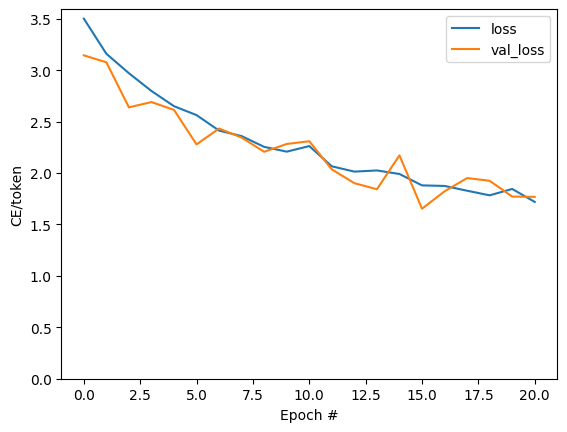

In [73]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

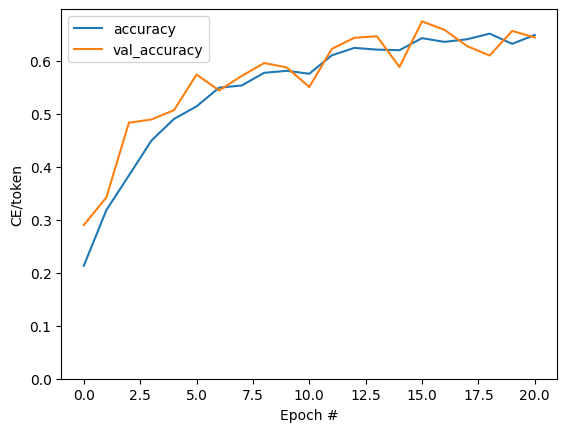

In [74]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [75]:
result = model.simple_gen(image, temperature=0.0)
result

'a man lying on the ground in a room'

In [76]:
str_tokens = result.split()
str_tokens.append('[END]')

In [77]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 2, 10, 49]), TensorShape([1, 2, 10, 49])]

In [78]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=7, width=7,
    reduction='mean')

In [79]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>

In [80]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)

    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

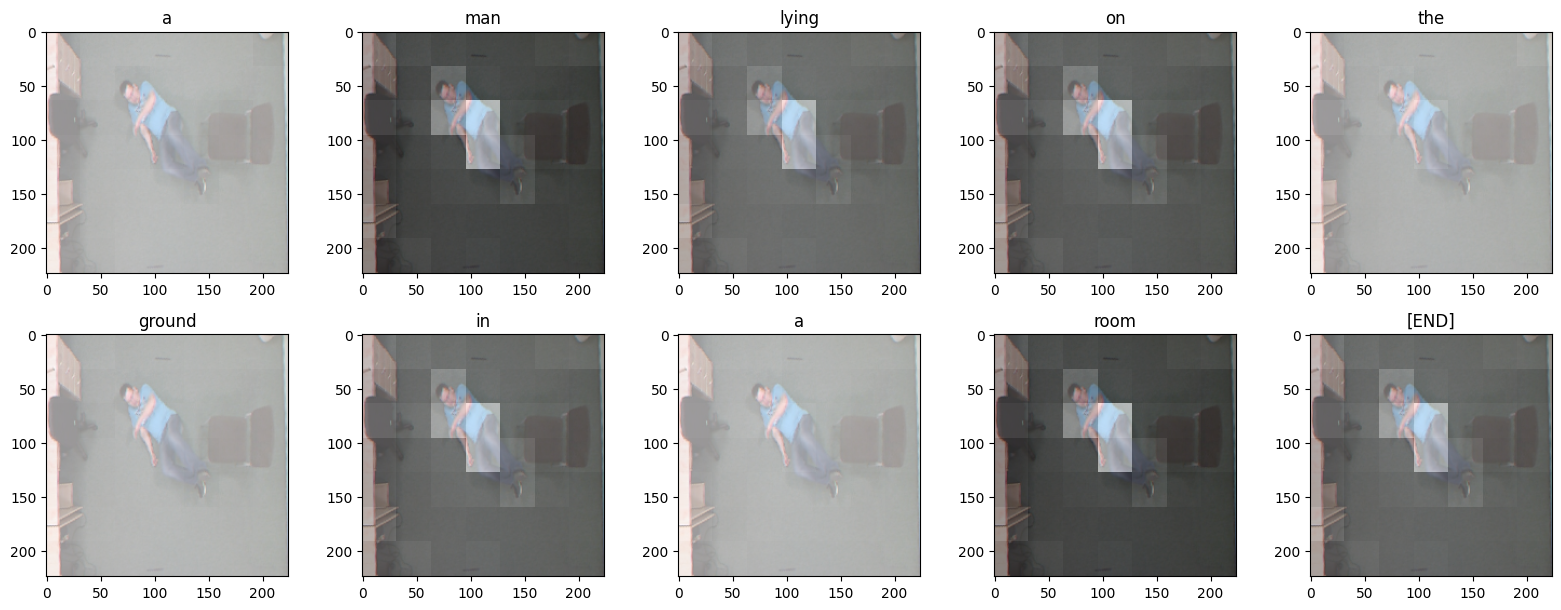

In [81]:
plot_attention_maps(image/255, str_tokens, attention_maps)

In [82]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):
  result_txt = self.simple_gen(image, temperature)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')

  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)


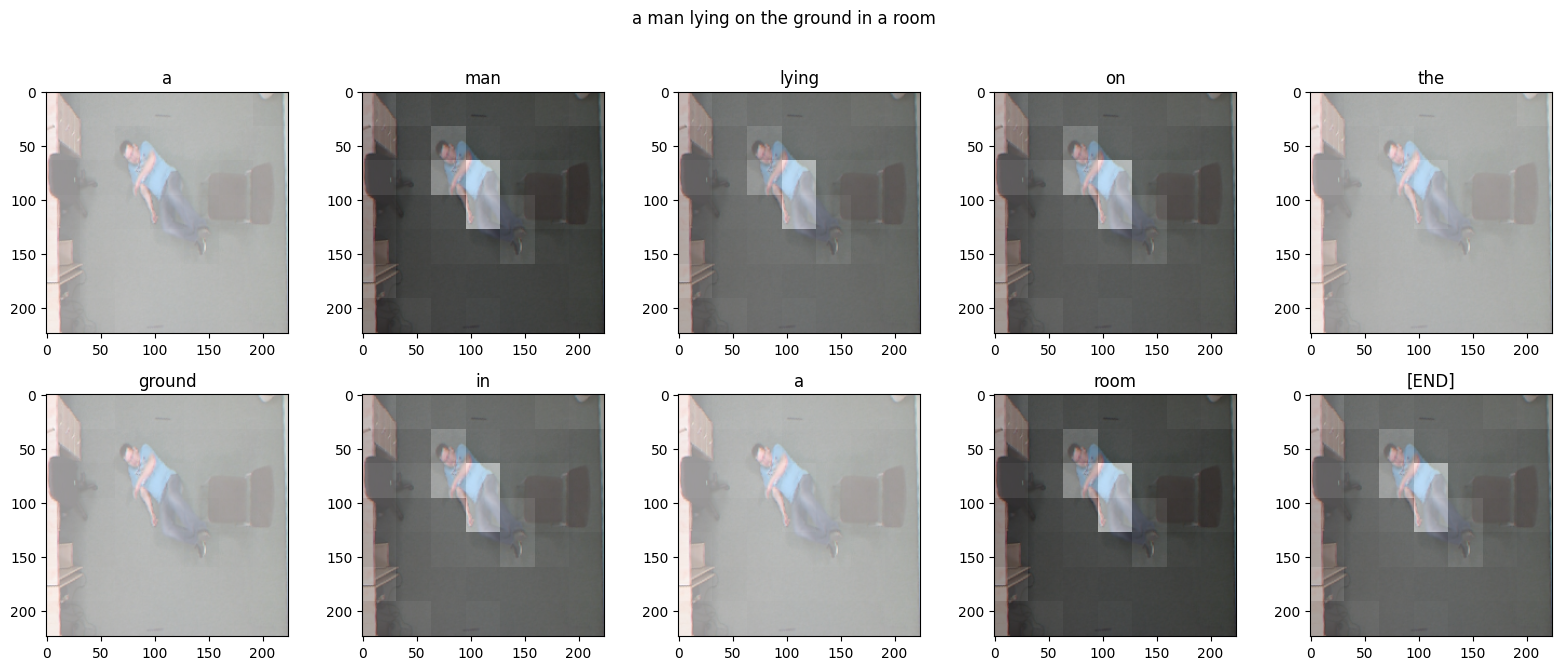

In [83]:
run_and_show_attention(model, image)

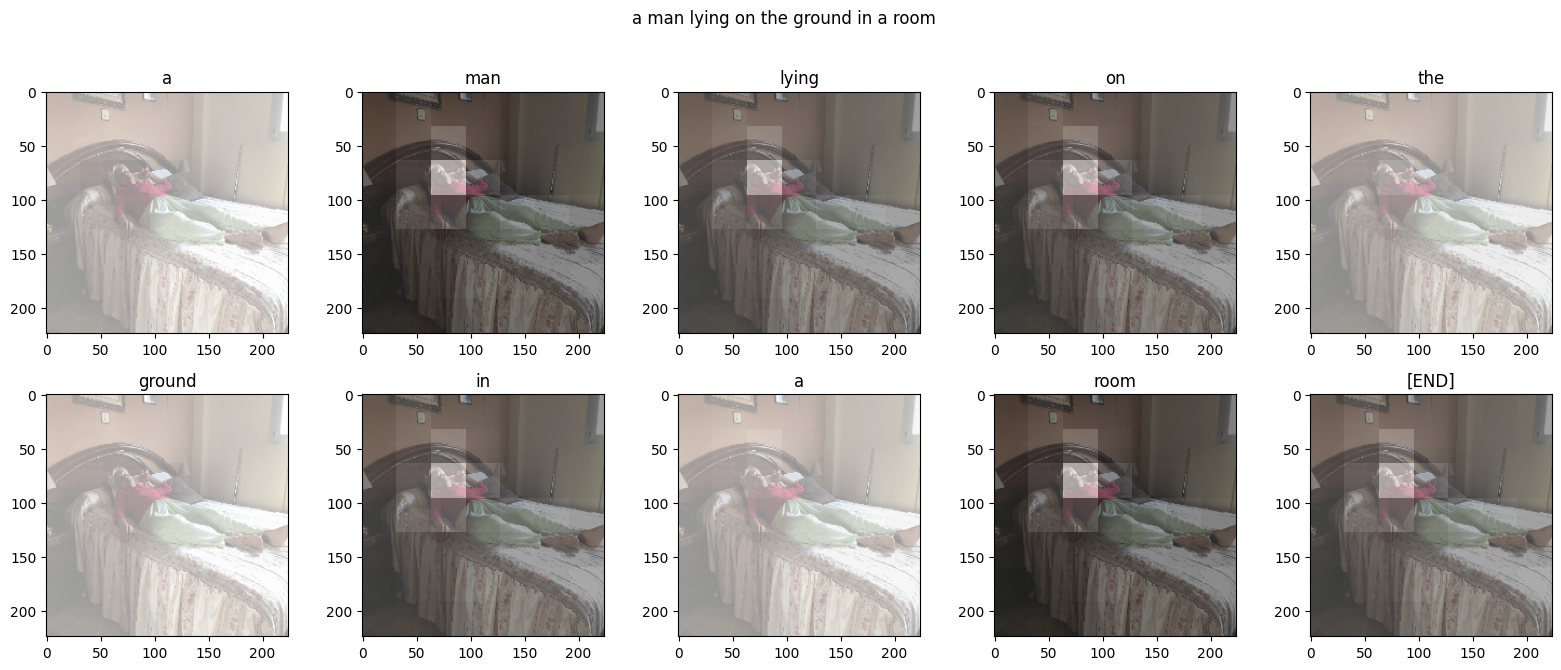

In [87]:
image_path = r"/content/drive/MyDrive/image_dataset_splited/test/Sleep/Sleep_008.jpg"
image = load_image(image_path)

run_and_show_attention(model, image)